# Importing Libraries

In [1]:
from pathlib import Path 
import pydicom
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

In [2]:
labels = pd.read_csv("rsna_heart_detection.csv")

In [3]:
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [4]:
ROOT_PATH = Path("../Pneumonia_classification/Data/stage_2_train_images/")
SAVE_PATH = Path("Processed_Heart_Detection/")

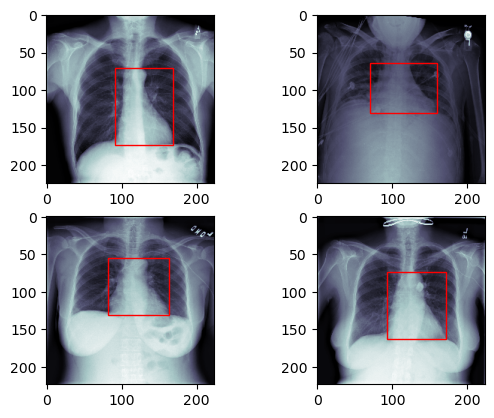

In [5]:
fig, axis = plt.subplots(2,2)
counter = 0
for i in range(2):
    for j in range(2):
        data = labels.iloc[counter]
        patient_id = data['name']
        dcm_path = ROOT_PATH/str(patient_id)
        dcm_path = dcm_path.with_suffix(".dcm")

        dcm = pydicom.read_file(dcm_path)
        dcm_array = dcm.pixel_array
        dcm_array = cv2.resize(dcm_array, (224,224))

        X = data["x0"]
        y = data["y0"]
        width = data["w"]
        height = data["h"]

        axis[i,j].imshow(dcm_array, cmap = "bone")
        rect = patches.Rectangle((X,y), width, height, linewidth = 1, edgecolor = "r", facecolor = "none")
        axis[i,j].add_patch(rect)
        counter += 1


In [6]:
sums, sums_squared = 0, 0
train_ids = []
val_ids = []

for k, patient_id in enumerate(list(labels.name)):
    dcm_path = ROOT_PATH/str(patient_id)
    dcm_path = dcm_path.with_suffix(".dcm")

    dcm = pydicom.read_file(dcm_path)
    dcm_array = dcm.pixel_array
    dcm_array = (cv2.resize(dcm_array, (224,224))/ 255).astype(np.float16)

    train_or_val = "train" if k < 400 else "val"

    if train_or_val == "train":
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)

    current_path = SAVE_PATH/train_or_val
    current_path.mkdir(parents = True, exist_ok=True)

    np.save(current_path/patient_id, dcm_array)

    z = 224*224 # Normalizing constant based on our image pixel size

    if train_or_val == "train":
        sums += np.sum(dcm_array)/z
        sums_squared += (dcm_array**2).sum()/z

In [7]:
np.save("train_subjects", train_ids)
np.save("val_subjects", val_ids)

In [14]:
mean = sums/len(train_ids)
std = np.sqrt(((sums_squared)/len(train_ids)) - mean**2)

In [15]:
print(f"Mean of the dataset: {mean:.2f}, Standard Deviation: {std:.2f}")

Mean of the dataset: 0.49, Standard Deviation: 0.25
